In [1]:
import matplotlib.pyplot as plt
import sys
from absl import app

# Addresses `UnrecognizedFlagError: Unknown command line flag 'f'`
sys.argv = sys.argv[:1]

# `app.run` calls `sys.exit`
try:
  app.run(lambda argv: None)
except:
  pass
%pip install dm-haiku
%pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 350 kB 13.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 12.4 MB/s 
     |████████████████████████████████| 85 kB 2.6 MB/s 


# qnn

# Main

In [2]:
import collections
import sys

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
from absl import app, flags
from tqdm import trange
from scipy import stats

dt = 1/365

def jumps_to_prices(jumps):
    jumps = jumps.reshape(jumps.shape[0], FLAGS.num_days * FLAGS.num_jumps)
    brownian = (jumps - FLAGS.bernoulli_p)  # mean 0
    brownian /= np.sqrt(FLAGS.bernoulli_p *
                        (1 - FLAGS.bernoulli_p))  # variance 1
    brownian = jnp.cumsum(brownian, axis=1)  # cumulative sum
    brownian /= np.sqrt( FLAGS.num_jumps)  # standardize
    brownian = brownian[:, FLAGS.num_jumps * np.arange(FLAGS.num_days)]
    t = jnp.arange(1, 1 + FLAGS.num_days) * dt
    log_prices = (FLAGS.mu - FLAGS.sigma**2 / 2) * t + FLAGS.sigma * jnp.sqrt(t) * brownian
    prices = jnp.exp(log_prices)
    prices = jnp.concatenate((jnp.ones((prices.shape[0], 1)), prices), axis=1)
    prices *= FLAGS.initial_price
    return prices[..., None]

def prices_to_BSdeltas(seq_prices):
  seq_prices = seq_prices[:,:-1]
  T = jnp.arange(1, FLAGS.num_days+1)*dt
  T = jnp.repeat(jnp.flip(T[None,:]), seq_prices.shape[0],0)
  d1 = jnp.divide(jnp.log(seq_prices[...,0]/FLAGS.strike_price)+ (FLAGS.mu + 0.5 * FLAGS.sigma **2)* T, FLAGS.sigma * jnp.sqrt(T))
  seq_bs_deltas = (stats.norm.cdf(d1, 0.0, 1.0))[...,None]
  seq_deltas = seq_bs_deltas
  seq_actions = jnp.concatenate(
            [seq_deltas[:, [0]], seq_deltas[:, 1:] - seq_deltas[:, :-1]],
            axis=1) 
  return seq_deltas, seq_actions

def build_actor_fn():
    def actor_fn(seq_jumps):
        seq_deltas = []
        seq_prices = jumps_to_prices(seq_jumps)
        for time_step in range(FLAGS.num_days):
            features = seq_prices[:, :time_step]
            features = features.reshape(features.shape[0], -1)
            net = hk.nets.MLP(FLAGS.hidden_layers*[FLAGS.hidden_units] + [1])
            deltas = 0.5 * (1 + jax.nn.tanh(net(features)))
            seq_deltas.append(deltas)
        seq_deltas = jnp.stack(seq_deltas, axis=1)
        seq_actions = jnp.concatenate(
            [seq_deltas[:, [0]], seq_deltas[:, 1:] - seq_deltas[:, :-1]],
            axis=1)
        return seq_deltas, seq_actions

    return actor_fn


def build_critic_fn(activation_fn=None):
    def critic_fn(seq_jumps, seq_deltas):
        seq_values = []
        seq_prices = jumps_to_prices(seq_jumps)
        for time_step in range(FLAGS.num_days):
            features = seq_prices[:, :time_step]
            features = features.reshape(features.shape[0], -1)
            net = hk.nets.MLP([FLAGS.hidden_units, FLAGS.hidden_units, 1])
            if activation_fn:
              values = activation_fn(net(features))
            else:
              values = net(features)
            seq_values.append(values)
        seq_values = jnp.stack(seq_values, axis=1)
        return seq_values

    return critic_fn




In [3]:
import math 
def binom(n, k):
    return math.factorial(n) // math.factorial(k) // math.factorial(n - k)
def build_critic_distributional_fn(activation_fn=None):
    def critic_fn(seq_jumps, seq_deltas):
        seq_values = []
        seq_dist_values = []
        seq_prices = jumps_to_prices(seq_jumps)
        for time_step in range(FLAGS.num_days):
            features = seq_prices[:, :time_step]
            features = features.reshape(features.shape[0], -1)
            net = hk.nets.MLP([FLAGS.hidden_units, FLAGS.hidden_units, FLAGS.num_days - time_step + 1])
            if activation_fn:
              dist_values = activation_fn(net(features))
            else:
              dist_values = net(features)
            dist_probs = jnp.array([binom(FLAGS.num_days - time_step, k) for k in range(FLAGS.num_days - time_step+1)])
            dist_probs /= 2** (FLAGS.num_days - time_step)
            values = jnp.einsum('i,...i->...', dist_probs, dist_values)
            values = values[...,None]            
            seq_values.append(values)
            seq_dist_values.append(dist_values)
        seq_values = jnp.stack(seq_values, axis=1)
        return seq_values, seq_dist_values

    return critic_fn


In [4]:
def dh_actor_critic_dist(critic_loss_version):
  np_random = np.random.RandomState(seed=FLAGS.seed)
  rng_key = hk.PRNGSequence(np_random.randint(0, sys.maxsize + 1))
  actor_fn = build_actor_fn()
  actor_net = hk.transform(actor_fn)
  actor_params = actor_net.init(
      next(rng_key), jnp.ones((1, FLAGS.num_days, FLAGS.num_jumps)))
  actor_opt = optax.adamw(FLAGS.actor_lr)
  actor_state = actor_opt.init(actor_params)
  buffer = collections.deque(maxlen=FLAGS.num_buffer_episodes)
  critic_fn = build_critic_distributional_fn(jax.nn.softplus)
  critic_net = hk.transform(critic_fn)
  critic_params = critic_net.init(
      next(rng_key), jnp.ones((1, FLAGS.num_days, FLAGS.num_jumps)),
      jnp.ones((1, FLAGS.num_days, 1)))
  critic_opt = optax.adam(FLAGS.critic_lr)
  critic_state = critic_opt.init(critic_params)

  def critic_loss_fn(critic_params, key, seq_jumps,
                      seq_deltas, seq_rewards, seq_returns):
      critic_key, target_key = jax.random.split(key, 2)
      _ , seq_dist_values = critic_net.apply(critic_params, critic_key, seq_jumps,
                                    seq_deltas)
      preds = []
      for time_step in range(FLAGS.num_days):
        future = seq_jumps[:,time_step:,0]
        weight = future.sum(axis=-1)
        pred = jax.vmap(jax.lax.dynamic_index_in_dim)(seq_dist_values[time_step],jnp.int32(weight))
        preds.append(pred)
      preds = jnp.stack(preds,axis=1)
      seq_values = preds
      print
      if critic_loss_version==0:
          loss = (jnp.exp(-FLAGS.lamda * seq_returns)
          - seq_values)**2
      elif critic_loss_version==1:
           loss = 1 / FLAGS.lamda * jnp.exp(
          -FLAGS.lamda * (seq_targets - seq_values)) - seq_values
      return loss.mean()

  @jax.jit
  def critic_train_step(critic_params, critic_state, key,
                        seq_jumps, seq_deltas, seq_rewards, seq_returns):
      loss, grad = jax.value_and_grad(critic_loss_fn)(
          critic_params, key, seq_jumps, seq_deltas,
          seq_rewards, seq_returns)
      updates, critic_state = critic_opt.update(grad, critic_state,
                                                critic_params)
      critic_new_params = optax.apply_updates(critic_params, updates)
      critic_params = jax.tree_util.tree_map(
          lambda x, y: (1 - FLAGS.critic_tau) * x + FLAGS.critic_tau * y,
          critic_new_params, critic_params)
      return critic_params, critic_state, loss

  def actor_loss_fn(actor_params, critic_params, key, seq_jumps):
      critic_key, actor_key = jax.random.split(key, 2)
      seq_deltas, seq_actions = actor_net.apply(actor_params, actor_key,
                                                seq_jumps)
      seq_values, _ = critic_net.apply(critic_params, critic_key, seq_jumps,
                                    seq_deltas)
      seq_prices = jumps_to_prices(seq_jumps)
      seq_rewards = -(jnp.abs(seq_actions) * FLAGS.cost_eps +
                      seq_actions) * seq_prices[:, :-1]
      final_actions = -seq_deltas[:, -1]
      final_rewards = jnp.maximum(
          seq_prices[:, -1] - FLAGS.strike_price,
          0) - (jnp.abs(final_actions) * FLAGS.cost_eps +
                final_actions) * seq_prices[:, -1]
      seq_values = jnp.concatenate(
          [seq_values[:, 1:], final_rewards[..., None]], axis=1)
      # loss =  -(seq_rewards - jnp.log(
      #     1 / FLAGS.lamda * seq_values))
      # loss = 1 / FLAGS.lamda * jnp.exp(-FLAGS.lamda *
      #                                   (seq_rewards + seq_values))
      loss  = -(seq_rewards[0, 0] - 1/FLAGS.lamda* jnp.log( seq_values))
      return loss.mean()

  @jax.jit
  def actor_train_step(actor_params, critic_params, actor_state, key,
                        seq_jumps):
      loss, grad = jax.value_and_grad(actor_loss_fn)(actor_params,
                                                      critic_params, key,
                                                      seq_jumps)
      updates, actor_state = actor_opt.update(grad, actor_state,
                                              actor_params)
      actor_params = optax.apply_updates(actor_params, updates)
      return actor_params, actor_state, loss

  @jax.jit
  def rollout_step(actor_params, key, seq_jumps):
      seq_prices = jumps_to_prices(seq_jumps)
      seq_deltas, seq_actions = actor_net.apply(actor_params, key,
                                                seq_jumps)
      seq_rewards = -(jnp.abs(seq_actions) * FLAGS.cost_eps +
                      seq_actions) * seq_prices[:, :-1]
      final_actions = -seq_deltas[:, -1]
      final_rewards = jnp.maximum(
          seq_prices[:, -1] - FLAGS.strike_price,
          0) - (jnp.abs(final_actions) * FLAGS.cost_eps +
                final_actions) * seq_prices[:, -1]
      seq_next_rewards = jnp.concatenate(
          [seq_rewards[:, 1:], final_rewards[..., None]], axis=1)
      seq_returns = jnp.cumsum(seq_next_rewards[:, ::-1],
                                axis=-1)[:, ::-1]
      return seq_deltas, seq_actions, seq_rewards, seq_returns
  def eval_step(actor_params, key, seq_jumps):
      seq_prices = jumps_to_prices(seq_jumps)
      seq_deltas, seq_actions = actor_net.apply(actor_params, key, seq_jumps)
      seq_rewards = -(jnp.abs(seq_actions) * FLAGS.cost_eps +
                      seq_actions) * seq_prices[:, :-1]
      seq_returns = jnp.sum(seq_rewards[:, 1:], axis=1)
      final_actions = -seq_deltas[:, -1]
      final_rewards = jnp.maximum(
          seq_prices[:, -1] - FLAGS.strike_price,
          0) - (jnp.abs(final_actions) * FLAGS.cost_eps +
                final_actions) * seq_prices[:, -1]
      seq_returns += final_rewards
      eval_returns = seq_rewards[0, 0] - jnp.log(
          1 / FLAGS.lamda * jnp.exp(-FLAGS.lamda * seq_returns).mean())
      return eval_returns
  plot_info = {}
  plot_info['utility'] = []
  plot_info['actor_loss'] = []
  plot_info['critic_loss'] = []
  with trange(FLAGS.num_train_steps) as t:
      for train_step in t:
          # Rollout
          shape = (FLAGS.num_rollout_episodes, FLAGS.num_days,
                  FLAGS.num_jumps)
          seq_jumps = jax.random.bernoulli(next(rng_key),
                                          shape=shape,
                                          p=FLAGS.bernoulli_p)
          seq_deltas, seq_actions, seq_rewards, seq_returns = rollout_step(
              actor_params, next(rng_key), seq_jumps)
          for episode in range(FLAGS.num_rollout_episodes):
              buffer.append(
                  tuple(seq[episode] for seq in (seq_jumps, seq_deltas,
                                                seq_rewards, seq_returns)))
          # Train critic
          critic_idxs = np_random.randint(0,
                                          len(buffer),
                                          size=FLAGS.num_critic_episodes)
          critic_episodes = [buffer[idx] for idx in critic_idxs]
          seq_jumps, seq_deltas, seq_rewards, seq_returns = (
              jnp.asarray(seq) for seq in zip(*critic_episodes))
          critic_params, critic_state, critic_loss = critic_train_step(
              critic_params, critic_state, next(rng_key),
              seq_jumps, seq_deltas, seq_rewards, seq_returns)

          # Train actor
          actor_idxs = np_random.randint(0,
                                        len(buffer),
                                        size=FLAGS.num_actor_episodes)
          actor_episodes = [buffer[idx] for idx in actor_idxs]
          seq_jumps, _, _, _ = (jnp.asarray(seq)
                                for seq in zip(*actor_episodes))
          actor_params, actor_state, actor_loss = actor_train_step(
              actor_params, critic_params, actor_state, next(rng_key),
              seq_jumps)

          # Evaluate
          shape = (FLAGS.num_eval_episodes, FLAGS.num_days, FLAGS.num_jumps)
          seq_jumps = jax.random.bernoulli(next(rng_key),
                                          shape=shape,
                                          p=FLAGS.bernoulli_p)
          eval_returns = eval_step(actor_params, next(rng_key), seq_jumps)
          plot_info['utility'].append(eval_returns.mean())
          plot_info['actor_loss'].append(actor_loss)
          plot_info['critic_loss'].append(critic_loss)
          t.set_postfix(utility=eval_returns.mean(), actor_loss=actor_loss,critic_loss=critic_loss)
  return plot_info

In [ ]:
FLAGS = flags.FLAGS
# Delete all existing attributes in flag before defining any new
for name in list(flags.FLAGS): 
      delattr(flags.FLAGS,name)
flags.DEFINE_integer("seed", 42, "Random seed.")
flags.DEFINE_integer("num_days", 8, "Number of days per episode.")
flags.DEFINE_integer("num_trading_days", 251, "Number of trading days in year.")
flags.DEFINE_integer("num_jumps", 1, "Number jumps per day.")
flags.DEFINE_float("bernoulli_p", 0.5, "Bernoulli p of Wiener process.")
flags.DEFINE_float("mu", 0., "Drift of Wiener process.")
flags.DEFINE_float("sigma", 0.2, "Volatility of Wiener process.")
flags.DEFINE_float("initial_price", 100., "Initial price.")
flags.DEFINE_float("strike_price", 100., "Strike price.")
flags.DEFINE_float("lamda", 0.1, "Risk-measure factor.")
flags.DEFINE_float("cost_eps", 0., "Cost epsilon.")
flags.DEFINE_integer("num_train_steps", 500, "Number of train steps.")
flags.DEFINE_integer("num_actor_episodes", 16, "Number of actor episodes.")
flags.DEFINE_integer("num_eval_episodes", 128, "Number of eval episodes.")
flags.DEFINE_float("actor_lr", 1E-1, "Actor learning rate.")
flags.DEFINE_integer("hidden_units", 16, "Number of hidden units.")
flags.DEFINE_integer("hidden_layers", 2, "Number of hidden layers.")
flags.DEFINE_integer("num_buffer_episodes", 64,
                      "Number of buffer episodes.")
flags.DEFINE_integer("num_critic_episodes", 64,
                      "Number of critic episodes.")
flags.DEFINE_integer("num_rollout_episodes", 64,
                      "Number of rollout episodes.")
flags.DEFINE_float("critic_lr", 1E-2, "Critic learning rate.")
flags.DEFINE_float("critic_tau", 0.001, "Critic target smoothing factor.")
FLAGS(sys.argv)
distributional_actor_critic_info  = dh_actor_critic_dist(critic_loss_version=0)

In [ ]:
def dh_vanilla():
  np_random = np.random.RandomState(seed=FLAGS.seed)
  rng_key = hk.PRNGSequence(np_random.randint(0, sys.maxsize + 1))
  actor_fn = build_actor_fn()
  actor_net = hk.transform(actor_fn)
  actor_params = actor_net.init(
      next(rng_key), jnp.ones((1, FLAGS.num_days, FLAGS.num_jumps)))
  actor_opt = optax.adamw(FLAGS.actor_lr)
  actor_state = actor_opt.init(actor_params)
  def actor_loss_fn(actor_params, key, seq_jumps):
      seq_prices = jumps_to_prices(seq_jumps)
      seq_deltas, seq_actions = actor_net.apply(actor_params, key,
                                                seq_jumps)
      seq_rewards = -(jnp.abs(seq_actions) * FLAGS.cost_eps +
                      seq_actions) * seq_prices[:, :-1]
      seq_returns = jnp.sum(seq_rewards[:, 1:], axis=1)
      final_actions = -seq_deltas[:, -1]
      final_rewards = -jnp.maximum(
          seq_prices[:, -1] - FLAGS.strike_price,
          0) - (jnp.abs(final_actions) * FLAGS.cost_eps +
                final_actions) * seq_prices[:, -1]
      seq_returns += final_rewards
      loss = -(seq_rewards[0, 0] - jnp.log(
          1 / FLAGS.lamda * jnp.exp(-FLAGS.lamda * seq_returns).mean()))
      return loss.mean()

  @jax.jit
  def actor_train_step(actor_params, actor_state, key, seq_jumps):
      loss, grad = jax.value_and_grad(actor_loss_fn)(actor_params, key,
                                                      seq_jumps)
      updates, actor_state = actor_opt.update(grad, actor_state,
                                              actor_params)
      actor_params = optax.apply_updates(actor_params, updates)
      return actor_params, actor_state, loss
  def eval_step(actor_params, key, seq_jumps):
        seq_prices = jumps_to_prices(seq_jumps)
        seq_deltas, seq_actions = actor_net.apply(actor_params, key, seq_jumps)
        seq_rewards = -(jnp.abs(seq_actions) * FLAGS.cost_eps +
                        seq_actions) * seq_prices[:, :-1]
        seq_returns = jnp.sum(seq_rewards[:, 1:], axis=1)
        final_actions = -seq_deltas[:, -1]
        final_rewards = -jnp.maximum(
            seq_prices[:, -1] - FLAGS.strike_price,
            0) - (jnp.abs(final_actions) * FLAGS.cost_eps +
                  final_actions) * seq_prices[:, -1]
        seq_returns += final_rewards
        eval_returns = seq_rewards[0, 0] - jnp.log(
            1 / FLAGS.lamda * jnp.exp(-FLAGS.lamda * seq_returns).mean())
        return eval_returns
  def eval_BS(seq_jumps):
    seq_prices = jumps_to_prices(seq_jumps)
    seq_deltas,seq_actions = prices_to_BSdeltas(seq_prices)
    seq_rewards = -(jnp.abs(seq_actions) * FLAGS.cost_eps +
                        seq_actions) * seq_prices[:, :-1]
    seq_returns = jnp.sum(seq_rewards[:, 1:], axis=1)
    final_actions = -seq_deltas[:, -1]
    final_rewards = jnp.maximum(
        seq_prices[:, -1] - FLAGS.strike_price,
        0) - (jnp.abs(final_actions) * FLAGS.cost_eps +
              final_actions) * seq_prices[:, -1]
    seq_returns += final_rewards
    eval_returns = seq_rewards[0, 0] - jnp.log(
        1 / FLAGS.lamda * jnp.exp(-FLAGS.lamda * seq_returns).mean())
    return eval_returns

  plot_info = {}
  plot_info['actor_loss'] = []
  plot_info['utility'] = []
  plot_info['BS utility'] = []
  with trange(FLAGS.num_train_steps) as t:
      for train_step in t:
          # Train Actor
          shape = (FLAGS.num_actor_episodes, FLAGS.num_days, FLAGS.num_jumps)
          seq_jumps = jax.random.bernoulli(next(rng_key),
                                          shape=shape,
                                          p=FLAGS.bernoulli_p)
          actor_params, actor_state, actor_loss = actor_train_step(
              actor_params, actor_state, next(rng_key), seq_jumps)
          # Evaluate
          shape = (FLAGS.num_eval_episodes, FLAGS.num_days, FLAGS.num_jumps)
          seq_jumps = jax.random.bernoulli(next(rng_key),
                                          shape=shape,
                                          p=FLAGS.bernoulli_p)
          eval_returns = eval_step(actor_params, next(rng_key), seq_jumps)
          BS_returns = eval_BS(seq_jumps)
          plot_info['actor_loss'].append(actor_loss)
          plot_info['utility'].append(eval_returns.mean())
          plot_info['BS utility'].append(BS_returns.mean())
          t.set_postfix(utility=eval_returns.mean(),BS_utility=BS_returns.mean(),actor_loss=actor_loss)
  return plot_info


In [ ]:
FLAGS = flags.FLAGS
# Delete all existing attributes in flag before defining any new
for name in list(flags.FLAGS): 
      delattr(flags.FLAGS,name)
flags.DEFINE_integer("seed", 42, "Random seed.")
flags.DEFINE_integer("num_days", 8, "Number of days per episode.")
flags.DEFINE_integer("num_jumps", 1, "Number jumps per day.")
flags.DEFINE_float("bernoulli_p", 0.5, "Bernoulli p of Wiener process.")
flags.DEFINE_float("mu", 0., "Drift of Wiener process.")
flags.DEFINE_float("sigma", 0.2, "Volatility of Wiener process.")
flags.DEFINE_float("initial_price", 100., "Initial price.")
flags.DEFINE_float("strike_price", 100., "Strike price.")
flags.DEFINE_float("lamda", 0.1, "Risk-measure factor.")
flags.DEFINE_float("cost_eps", 0., "Cost epsilon.")
flags.DEFINE_integer("num_train_steps", 500, "Number of train steps.")
flags.DEFINE_integer("num_actor_episodes", 16, "Number of actor episodes.")
flags.DEFINE_integer("num_eval_episodes", 128, "Number of eval episodes.")
flags.DEFINE_float("actor_lr", 1E-1, "Actor learning rate.")
flags.DEFINE_integer("hidden_units", 8, "Number of hidden units.")
flags.DEFINE_integer("hidden_layers", 2, "Number of hidden layers.")
dh_vanilla_info = dh_vanilla()

100%|██████████| 500/500 [00:47<00:00, 10.46it/s, BS_utility=-47.712574, actor_loss=2.7781162, utility=-2.6838903]


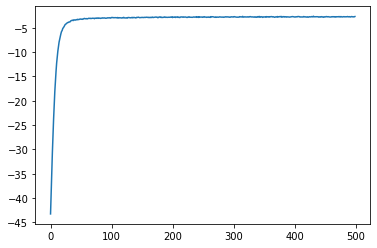

In [ ]:
plt.plot(dh_vanilla_info['utility'])

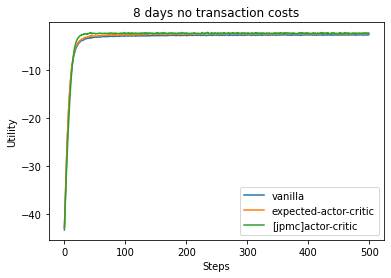

In [ ]:
plt.plot()
plt.title('8 days no transaction costs')
plt.xlabel('Steps')
plt.ylabel('Utility')
plt.plot(dh_vanilla_info['utility'],label='vanilla')
# plt.plot(distributional_actor_critic_info['utility'],label='distributional-actor-critic')
plt.plot(dh_expected_actor_critic_info['utility'],label='expected-actor-critic')
plt.plot(jp_ac_info['utility'],label='[jpmc]actor-critic')
plt.legend()

In [ ]:
def dh_actor_critic_v0(critic_loss_version):
  np_random = np.random.RandomState(seed=FLAGS.seed)
  rng_key = hk.PRNGSequence(np_random.randint(0, sys.maxsize + 1))
  actor_fn = build_actor_fn()
  actor_net = hk.transform(actor_fn)
  actor_params = actor_net.init(
      next(rng_key), jnp.ones((1, FLAGS.num_days, FLAGS.num_jumps)))
  actor_opt = optax.adamw(FLAGS.actor_lr)
  actor_state = actor_opt.init(actor_params)
  buffer = collections.deque(maxlen=FLAGS.num_buffer_episodes)
  critic_fn = build_critic_fn(activation_fn=jax.nn.softplus)
  critic_net = hk.transform(critic_fn)
  critic_params = critic_net.init(
      next(rng_key), jnp.ones((1, FLAGS.num_days, FLAGS.num_jumps)),
      jnp.ones((1, FLAGS.num_days, 1)))
  critic_opt = optax.adam(FLAGS.critic_lr)
  critic_state = critic_opt.init(critic_params)

  def critic_loss_fn(critic_params, key, seq_jumps,
                      seq_deltas, seq_rewards, seq_returns):
      critic_key, target_key = jax.random.split(key, 2)
      seq_values = critic_net.apply(critic_params, critic_key, seq_jumps,
                                    seq_deltas)
      seq_targets = seq_returns
      if critic_loss_version==0:
          loss = (jnp.exp(-FLAGS.lamda * seq_targets)
          - seq_values)**2
      elif critic_loss_version==1:
           loss = 1 / FLAGS.lamda * jnp.exp(
          -FLAGS.lamda * (seq_targets - seq_values)) - seq_values
      return loss.mean()

  @jax.jit
  def critic_train_step(critic_params, critic_state, key,
                        seq_jumps, seq_deltas, seq_rewards, seq_returns):
      loss, grad = jax.value_and_grad(critic_loss_fn)(
          critic_params, key, seq_jumps, seq_deltas,
          seq_rewards, seq_returns)
      updates, critic_state = critic_opt.update(grad, critic_state,
                                                critic_params)
      critic_new_params = optax.apply_updates(critic_params, updates)
      critic_params = jax.tree_util.tree_map(
          lambda x, y: (1 - FLAGS.critic_tau) * x + FLAGS.critic_tau * y,
          critic_new_params, critic_params)
      return critic_params, critic_state, loss

  def actor_loss_fn(actor_params, critic_params, key, seq_jumps):
      critic_key, actor_key = jax.random.split(key, 2)
      seq_deltas, seq_actions = actor_net.apply(actor_params, actor_key,
                                                seq_jumps)
      seq_values = critic_net.apply(critic_params, critic_key, seq_jumps,
                                    seq_deltas)
      seq_prices = jumps_to_prices(seq_jumps)
      seq_rewards = -(jnp.abs(seq_actions) * FLAGS.cost_eps +
                      seq_actions) * seq_prices[:, :-1]
      final_actions = -seq_deltas[:, -1]
      final_rewards = jnp.maximum(
          seq_prices[:, -1] - FLAGS.strike_price,
          0) - (jnp.abs(final_actions) * FLAGS.cost_eps +
                final_actions) * seq_prices[:, -1]
      seq_values = jnp.concatenate(
          [seq_values[:, 1:], final_rewards[..., None]], axis=1)
      # loss =  -(seq_rewards - jnp.log(
      #     1 / FLAGS.lamda * seq_values))
      # loss = 1 / FLAGS.lamda * jnp.exp(-FLAGS.lamda *
      #                                   (seq_rewards + seq_values))
      loss  = -(seq_rewards[0, 0] - 1/FLAGS.lamda* jnp.log( seq_values))
      return loss.mean()

  @jax.jit
  def actor_train_step(actor_params, critic_params, actor_state, key,
                        seq_jumps):
      loss, grad = jax.value_and_grad(actor_loss_fn)(actor_params,
                                                      critic_params, key,
                                                      seq_jumps)
      updates, actor_state = actor_opt.update(grad, actor_state,
                                              actor_params)
      actor_params = optax.apply_updates(actor_params, updates)
      return actor_params, actor_state, loss

  @jax.jit
  def rollout_step(actor_params, key, seq_jumps):
      seq_prices = jumps_to_prices(seq_jumps)
      seq_deltas, seq_actions = actor_net.apply(actor_params, key,
                                                seq_jumps)
      seq_rewards = -(jnp.abs(seq_actions) * FLAGS.cost_eps +
                      seq_actions) * seq_prices[:, :-1]
      final_actions = -seq_deltas[:, -1]
      final_rewards = jnp.maximum(
          seq_prices[:, -1] - FLAGS.strike_price,
          0) - (jnp.abs(final_actions) * FLAGS.cost_eps +
                final_actions) * seq_prices[:, -1]
      seq_next_rewards = jnp.concatenate(
          [seq_rewards[:, 1:], final_rewards[..., None]], axis=1)
      seq_returns = jnp.cumsum(seq_next_rewards[:, ::-1],
                                axis=-1)[:, ::-1]
      return seq_deltas, seq_actions, seq_rewards, seq_returns
  def eval_step(actor_params, key, seq_jumps):
      seq_prices = jumps_to_prices(seq_jumps)
      seq_deltas, seq_actions = actor_net.apply(actor_params, key, seq_jumps)
      seq_rewards = -(jnp.abs(seq_actions) * FLAGS.cost_eps +
                      seq_actions) * seq_prices[:, :-1]
      seq_returns = jnp.sum(seq_rewards[:, 1:], axis=1)
      final_actions = -seq_deltas[:, -1]
      final_rewards = jnp.maximum(
          seq_prices[:, -1] - FLAGS.strike_price,
          0) - (jnp.abs(final_actions) * FLAGS.cost_eps +
                final_actions) * seq_prices[:, -1]
      seq_returns += final_rewards
      eval_returns = seq_rewards[0, 0] - jnp.log(
          1 / FLAGS.lamda * jnp.exp(-FLAGS.lamda * seq_returns).mean())
      return eval_returns
  plot_info = {}
  plot_info['utility'] = []
  plot_info['actor_loss'] = []
  plot_info['critic_loss'] = []
  with trange(FLAGS.num_train_steps) as t:
      for train_step in t:
          # Rollout
          shape = (FLAGS.num_rollout_episodes, FLAGS.num_days,
                  FLAGS.num_jumps)
          seq_jumps = jax.random.bernoulli(next(rng_key),
                                          shape=shape,
                                          p=FLAGS.bernoulli_p)
          seq_deltas, seq_actions, seq_rewards, seq_returns = rollout_step(
              actor_params, next(rng_key), seq_jumps)
          for episode in range(FLAGS.num_rollout_episodes):
              buffer.append(
                  tuple(seq[episode] for seq in (seq_jumps, seq_deltas,
                                                seq_rewards, seq_returns)))
          # Train critic
          critic_idxs = np_random.randint(0,
                                          len(buffer),
                                          size=FLAGS.num_critic_episodes)
          critic_episodes = [buffer[idx] for idx in critic_idxs]
          seq_jumps, seq_deltas, seq_rewards, seq_returns = (
              jnp.asarray(seq) for seq in zip(*critic_episodes))
          critic_params, critic_state, critic_loss = critic_train_step(
              critic_params, critic_state, next(rng_key),
              seq_jumps, seq_deltas, seq_rewards, seq_returns)

          # Train actor
          actor_idxs = np_random.randint(0,
                                        len(buffer),
                                        size=FLAGS.num_actor_episodes)
          actor_episodes = [buffer[idx] for idx in actor_idxs]
          seq_jumps, _, _, _ = (jnp.asarray(seq)
                                for seq in zip(*actor_episodes))
          actor_params, actor_state, actor_loss = actor_train_step(
              actor_params, critic_params, actor_state, next(rng_key),
              seq_jumps)

          # Evaluate
          shape = (FLAGS.num_eval_episodes, FLAGS.num_days, FLAGS.num_jumps)
          seq_jumps = jax.random.bernoulli(next(rng_key),
                                          shape=shape,
                                          p=FLAGS.bernoulli_p)
          eval_returns = eval_step(actor_params, next(rng_key), seq_jumps)
          plot_info['utility'].append(eval_returns.mean())
          plot_info['actor_loss'].append(actor_loss)
          plot_info['critic_loss'].append(critic_loss)
          t.set_postfix(utility=eval_returns.mean(), actor_loss=actor_loss,critic_loss=critic_loss)
  return plot_info

In [ ]:
FLAGS = flags.FLAGS
# Delete all existing attributes in flag before defining any new
for name in list(flags.FLAGS): 
      delattr(flags.FLAGS,name)
flags.DEFINE_integer("seed", 42, "Random seed.")
flags.DEFINE_integer("num_days", 8, "Number of days per episode.")
flags.DEFINE_integer("num_trading_days", 251, "Number of trading days in year.")
flags.DEFINE_integer("num_jumps", 1, "Number jumps per day.")
flags.DEFINE_float("bernoulli_p", 0.5, "Bernoulli p of Wiener process.")
flags.DEFINE_float("mu", 0., "Drift of Wiener process.")
flags.DEFINE_float("sigma", 0.2, "Volatility of Wiener process.")
flags.DEFINE_float("initial_price", 100., "Initial price.")
flags.DEFINE_float("strike_price", 100., "Strike price.")
flags.DEFINE_float("lamda", 0.1, "Risk-measure factor.")
flags.DEFINE_float("cost_eps", 0., "Cost epsilon.")
flags.DEFINE_integer("num_train_steps", 500, "Number of train steps.")
flags.DEFINE_integer("num_actor_episodes", 16, "Number of actor episodes.")
flags.DEFINE_integer("num_eval_episodes", 128, "Number of eval episodes.")
flags.DEFINE_float("actor_lr", 1E-1, "Actor learning rate.")
flags.DEFINE_integer("hidden_units", 16, "Number of hidden units.")
flags.DEFINE_integer("hidden_layers", 2, "Number of hidden layers.")
flags.DEFINE_integer("num_buffer_episodes", 64,
                      "Number of buffer episodes.")
flags.DEFINE_integer("num_critic_episodes", 64,
                      "Number of critic episodes.")
flags.DEFINE_integer("num_rollout_episodes", 64,
                      "Number of rollout episodes.")
flags.DEFINE_float("critic_lr", 1E-2, "Critic learning rate.")
flags.DEFINE_float("critic_tau", 0.001, "Critic target smoothing factor.")
FLAGS(sys.argv)
dh_expected_actor_critic_info  = dh_actor_critic_v0(critic_loss_version=0)

100%|██████████| 500/500 [02:02<00:00,  4.07it/s, actor_loss=-inf, critic_loss=89049704.0, utility=-2.4364672]


In [ ]:
def dh_actor_critic_jp():
  np_random = np.random.RandomState(seed=FLAGS.seed)
  rng_key = hk.PRNGSequence(np_random.randint(0, sys.maxsize + 1))
  actor_fn = build_actor_fn()
  actor_net = hk.transform(actor_fn)
  actor_params = actor_net.init(
      next(rng_key), jnp.ones((1, FLAGS.num_days, FLAGS.num_jumps)))
  actor_opt = optax.adamw(FLAGS.actor_lr)
  actor_state = actor_opt.init(actor_params)
  buffer = collections.deque(maxlen=FLAGS.num_buffer_episodes)
  critic_fn = build_critic_fn()
  critic_net = hk.transform(critic_fn)
  critic_params = target_params = critic_net.init(
      next(rng_key), jnp.ones((1, FLAGS.num_days, FLAGS.num_jumps)),
      jnp.ones((1, FLAGS.num_days, 1)))
  critic_opt = optax.adam(FLAGS.critic_lr)
  critic_state = critic_opt.init(critic_params)

  def critic_loss_fn(critic_params, target_params, key, seq_jumps,
                      seq_deltas, seq_rewards, seq_returns):
      critic_key, target_key = jax.random.split(key, 2)
      seq_values = critic_net.apply(critic_params, critic_key, seq_jumps,
                                    seq_deltas)
      seq_target_values = critic_net.apply(target_params, target_key,
                                            seq_jumps, seq_deltas)
      last_target_values = seq_returns[:, -1][..., None]
      seq_target_values = jnp.concatenate(
          [seq_target_values[:, 1:], last_target_values], axis=1)
      seq_targets = seq_rewards + seq_target_values
      loss = 1 / FLAGS.lamda * jnp.exp(
          -FLAGS.lamda * (seq_targets - seq_values)) - seq_values
      return loss.mean()

  @jax.jit
  def critic_train_step(critic_params, target_params, critic_state, key,
                        seq_jumps, seq_deltas, seq_rewards, seq_returns):
      loss, grad = jax.value_and_grad(critic_loss_fn)(
          critic_params, target_params, key, seq_jumps, seq_deltas,
          seq_rewards, seq_returns)
      updates, critic_state = critic_opt.update(grad, critic_state,
                                                critic_params)
      critic_params = optax.apply_updates(critic_params, updates)
      target_params = jax.tree_util.tree_map(
          lambda x, y: (1 - FLAGS.critic_tau) * x + FLAGS.critic_tau * y,
          target_params, critic_params)
      # target_params = critic_params
      return critic_params, target_params, critic_state, loss

  def actor_loss_fn(actor_params, critic_params, key, seq_jumps):
      critic_key, actor_key = jax.random.split(key, 2)
      seq_deltas, seq_actions = actor_net.apply(actor_params, actor_key,
                                                seq_jumps)
      seq_values = critic_net.apply(critic_params, critic_key, seq_jumps,
                                    seq_deltas)
      seq_prices = jumps_to_prices(seq_jumps)
      seq_rewards = -(jnp.abs(seq_actions) * FLAGS.cost_eps +
                      seq_actions) * seq_prices[:, :-1]
      final_actions = -seq_deltas[:, -1]
      final_rewards = jnp.maximum(
          seq_prices[:, -1] - FLAGS.strike_price,
          0) - (jnp.abs(final_actions) * FLAGS.cost_eps +
                final_actions) * seq_prices[:, -1]
      seq_values = jnp.concatenate(
          [seq_values[:, 1:], final_rewards[..., None]], axis=1)
      loss = 1 / FLAGS.lamda * jnp.exp(-FLAGS.lamda *
                                        (seq_rewards + seq_values))
      return loss.mean()

  @jax.jit
  def actor_train_step(actor_params, critic_params, actor_state, key,
                        seq_jumps):
      loss, grad = jax.value_and_grad(actor_loss_fn)(actor_params,
                                                      critic_params, key,
                                                      seq_jumps)
      updates, actor_state = actor_opt.update(grad, actor_state,
                                              actor_params)
      actor_params = optax.apply_updates(actor_params, updates)
      return actor_params, actor_state, loss

  @jax.jit
  def rollout_step(actor_params, key, seq_jumps):
      seq_prices = jumps_to_prices(seq_jumps)
      seq_deltas, seq_actions = actor_net.apply(actor_params, key,
                                                seq_jumps)
      seq_rewards = -(jnp.abs(seq_actions) * FLAGS.cost_eps +
                      seq_actions) * seq_prices[:, :-1]
      final_actions = -seq_deltas[:, -1]
      final_rewards = jnp.maximum(
          seq_prices[:, -1] - FLAGS.strike_price,
          0) - (jnp.abs(final_actions) * FLAGS.cost_eps +
                final_actions) * seq_prices[:, -1]
      seq_next_rewards = jnp.concatenate(
          [seq_rewards[:, 1:], final_rewards[..., None]], axis=1)
      seq_returns = jnp.cumsum(seq_next_rewards[:, ::-1],
                                axis=-1)[:, ::-1]
      return seq_deltas, seq_actions, seq_rewards, seq_returns
  def eval_step(actor_params, key, seq_jumps):
      seq_prices = jumps_to_prices(seq_jumps)
      seq_deltas, seq_actions = actor_net.apply(actor_params, key, seq_jumps)
      seq_rewards = -(jnp.abs(seq_actions) * FLAGS.cost_eps +
                      seq_actions) * seq_prices[:, :-1]
      seq_returns = jnp.sum(seq_rewards[:, 1:], axis=1)
      final_actions = -seq_deltas[:, -1]
      final_rewards = jnp.maximum(
          seq_prices[:, -1] - FLAGS.strike_price,
          0) - (jnp.abs(final_actions) * FLAGS.cost_eps +
                final_actions) * seq_prices[:, -1]
      seq_returns += final_rewards
      eval_returns = seq_rewards[0, 0] - jnp.log(
          1 / FLAGS.lamda * jnp.exp(-FLAGS.lamda * seq_returns).mean())
      return eval_returns
  plot_info = {}
  plot_info['utility'] = []
  plot_info['actor_loss'] = []
  plot_info['critic_loss'] = []
  with trange(FLAGS.num_train_steps) as t:
      for train_step in t:
          # Rollout
          shape = (FLAGS.num_rollout_episodes, FLAGS.num_days,
                  FLAGS.num_jumps)
          seq_jumps = jax.random.bernoulli(next(rng_key),
                                          shape=shape,
                                          p=FLAGS.bernoulli_p)
          seq_deltas, seq_actions, seq_rewards, seq_returns = rollout_step(
              actor_params, next(rng_key), seq_jumps)
          for episode in range(FLAGS.num_rollout_episodes):
              buffer.append(
                  tuple(seq[episode] for seq in (seq_jumps, seq_deltas,
                                                seq_rewards, seq_returns)))
          # Train critic
          critic_idxs = np_random.randint(0,
                                          len(buffer),
                                          size=FLAGS.num_critic_episodes)
          critic_episodes = [buffer[idx] for idx in critic_idxs]
          seq_jumps, seq_deltas, seq_rewards, seq_returns = (
              jnp.asarray(seq) for seq in zip(*critic_episodes))
          critic_params, target_params, critic_state, critic_loss = critic_train_step(
              critic_params, target_params, critic_state, next(rng_key),
              seq_jumps, seq_deltas, seq_rewards, seq_returns)

          # Train actor
          actor_idxs = np_random.randint(0,
                                        len(buffer),
                                        size=FLAGS.num_actor_episodes)
          actor_episodes = [buffer[idx] for idx in actor_idxs]
          seq_jumps, _, _, _ = (jnp.asarray(seq)
                                for seq in zip(*actor_episodes))
          actor_params, actor_state, actor_loss = actor_train_step(
              actor_params, critic_params, actor_state, next(rng_key),
              seq_jumps)

          # Evaluate
          shape = (FLAGS.num_eval_episodes, FLAGS.num_days, FLAGS.num_jumps)
          seq_jumps = jax.random.bernoulli(next(rng_key),
                                          shape=shape,
                                          p=FLAGS.bernoulli_p)
          eval_returns = eval_step(actor_params, next(rng_key), seq_jumps)
          plot_info['utility'].append(eval_returns.mean())
          plot_info['actor_loss'].append(actor_loss)
          plot_info['critic_loss'].append(critic_loss)
          t.set_postfix(utility=eval_returns.mean(), actor_loss=actor_loss,critic_loss=critic_loss)
  return plot_info

In [ ]:
FLAGS = flags.FLAGS
# Delete all existing attributes in flag before defining any new
for name in list(flags.FLAGS): 
      delattr(flags.FLAGS,name)
flags.DEFINE_integer("seed", 42, "Random seed.")
flags.DEFINE_integer("num_days", 8, "Number of days per episode.")
flags.DEFINE_integer("num_jumps", 1, "Number jumps per day.")
flags.DEFINE_float("bernoulli_p", 0.5, "Bernoulli p of Wiener process.")
flags.DEFINE_float("mu", 0., "Drift of Wiener process.")
flags.DEFINE_float("sigma", 0.2, "Volatility of Wiener process.")
flags.DEFINE_float("initial_price", 100., "Initial price.")
flags.DEFINE_float("strike_price", 100., "Strike price.")
flags.DEFINE_float("lamda", 0.1, "Risk-measure factor.")
flags.DEFINE_float("cost_eps", 0., "Cost epsilon.")
flags.DEFINE_integer("num_train_steps", 500, "Number of train steps.")
flags.DEFINE_integer("num_actor_episodes", 16, "Number of actor episodes.")
flags.DEFINE_integer("num_eval_episodes", 128, "Number of eval episodes.")
flags.DEFINE_float("actor_lr", 1E-1, "Actor learning rate.")
flags.DEFINE_integer("hidden_units", 16, "Number of hidden units.")
flags.DEFINE_integer("hidden_layers", 2, "Number of hidden layers.")
flags.DEFINE_integer("num_buffer_episodes", 64,
                      "Number of buffer episodes.")
flags.DEFINE_integer("num_critic_episodes", 64,
                      "Number of critic episodes.")
flags.DEFINE_integer("num_rollout_episodes", 64,
                      "Number of rollout episodes.")
flags.DEFINE_float("critic_lr", 1E-2, "Critic learning rate.")
flags.DEFINE_float("critic_tau", 0.001, "Critic target smoothing factor.")
FLAGS(sys.argv)
jp_ac_info = dh_actor_critic_jp()